In [1]:
# Importing needed libraries

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import pickle

In [2]:
cars_list=pd.read_excel("Final_data.xlsx")

In [3]:
cars_list.columns

Index(['Unnamed: 0', 'Car_model', 'Year_of_car_manufacture',
       'Kilometers_driven', 'Number_of_previous_owners', 'Transmission_type',
       'Fuel_type', 'Body_type', 'Price_of_the_used_car', 'city'],
      dtype='object')

In [4]:
cars_list= cars_list.drop(['Unnamed: 0'],axis=1)

In [5]:
cars_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Car_model                  8369 non-null   object
 1   Year_of_car_manufacture    8369 non-null   int64 
 2   Kilometers_driven          8369 non-null   object
 3   Number_of_previous_owners  8369 non-null   int64 
 4   Transmission_type          8369 non-null   object
 5   Fuel_type                  8369 non-null   object
 6   Body_type                  8369 non-null   object
 7   Price_of_the_used_car      8369 non-null   object
 8   city                       8369 non-null   object
dtypes: int64(2), object(7)
memory usage: 588.6+ KB


In [6]:
cars_list.describe()

,Year_of_car_manufacture,Number_of_previous_owners
count,8369.000000,8369.000000
mean,2016.503286,1.360139
std,3.921465,0.641958
min,1985.000000,0.000000
25%,2014.000000,1.000000
50%,2017.000000,1.000000
75%,2019.000000,2.000000
max,2023.000000,5.000000


In [7]:
cars_list['Price_of_the_used_car'].value_counts()

Price_of_the_used_car
₹ 6.50 Lakh     106
₹ 4.50 Lakh      98
₹ 5 Lakh         97
₹ 3 Lakh         97
₹ 4 Lakh         90
               ... 
₹ 17.30 Lakh      1
₹ 9.01 Lakh       1
₹ 19.20 Lakh      1
₹ 1.03 Crore      1
₹ 14.30 Lakh      1
Name: count, Length: 1400, dtype: int64

In [8]:
# values with occurrence equal to 1
values_with_occurrence_one = cars_list['Price_of_the_used_car'].value_counts()
values_with_occurrence_one = values_with_occurrence_one[values_with_occurrence_one == 1]

print(values_with_occurrence_one)

Price_of_the_used_car
₹ 46.40 Lakh    1
₹ 1.73 Lakh     1
₹ 12.55 Lakh    1
₹ 78 Lakh       1
₹ 40.90 Lakh    1
               ..
₹ 17.30 Lakh    1
₹ 9.01 Lakh     1
₹ 19.20 Lakh    1
₹ 1.03 Crore    1
₹ 14.30 Lakh    1
Name: count, Length: 457, dtype: int64


In [9]:
#values with 'Crore' in the 'Price_of_the_used_car' column
crore_values = cars_list[cars_list['Price_of_the_used_car'].str.contains('Crore')]

print(crore_values['Price_of_the_used_car'])

131     ₹ 1.10 Crore
192     ₹ 1.18 Crore
287     ₹ 1.13 Crore
2242    ₹ 1.30 Crore
3448    ₹ 2.60 Crore
4397    ₹ 1.05 Crore
5235    ₹ 1.50 Crore
5966    ₹ 2.10 Crore
7048    ₹ 1.32 Crore
7056    ₹ 1.32 Crore
7099    ₹ 1.38 Crore
7183    ₹ 3.95 Crore
7199    ₹ 1.10 Crore
7207    ₹ 1.55 Crore
7227    ₹ 1.59 Crore
7279    ₹ 2.45 Crore
7366    ₹ 1.19 Crore
7367    ₹ 4.15 Crore
7407    ₹ 2.69 Crore
8189    ₹ 1.03 Crore
Name: Price_of_the_used_car, dtype: object


In [10]:
def convert_price(price_str):
    #  dictionary to map units to their numerical equivalents
    units = {'Lakh': 100000, 'Crore': 10000000}
    
    # Using regular expression to extract the numeric part and the unit
    match = re.match(r'₹ ([\d.]+) ([a-zA-Z]+)', price_str)
    
    if match:
        # Extracting the numeric part and the unit
        numeric_part = float(match.group(1))
        unit = match.group(2)
        
        return numeric_part * units.get(unit, 1)
    else:
        return None

cars_list['Price'] = cars_list['Price_of_the_used_car'].apply(convert_price)

In [11]:
# Replacing comma in values
cars_list['Kilometers_driven'] = cars_list['Kilometers_driven'].str.replace(',', '')

In [12]:
df_1= cars_list.drop(['Price_of_the_used_car'],axis=1).copy()

In [13]:
df_1.head(2)

,Car_model,Year_of_car_manufacture,Kilometers_driven,Number_of_previous_owners,Transmission_type,Fuel_type,Body_type,city,Price
0,Kia Sonet,2022,20000,1,Automatic,Petrol,SUV,Chennai,1150000.0
1,Maruti Eeco,2015,20687,1,Manual,Petrol,Minivans,Chennai,415000.0


In [14]:
# Plot for distribution of prices 

plt.figure(figsize=(6, 6))
fig = px.histogram(df_1, x='Price', title='Distribution of Prices')
fig.update_layout(xaxis_title='Price', yaxis_title='Frequency')
fig.show()


<Figure size 600x600 with 0 Axes>

In [15]:
df_1['Body_type'].mode()[0]

'Hatchback'

In [16]:
df_1['Price'].median()

np.float64(613000.0)

In [17]:
# Filling null values with mode
df_1['Body_type'] = df_1['Body_type'].fillna(df_1['Body_type'].mode()[0])

# Median imputation
df_1['Price'].fillna(df_1['Price'].median(), inplace=True)

C:\Users\Vijay\AppData\Local\Temp\ipykernel_9376\4132142369.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [19]:
# Boxplot for kms driven

fig = px.box(df_1, x='Kilometers_driven', y='Price', title='Boxplot of Kilometers Driven vs. Price')
fig.update_layout(xaxis_title='Kilometers Driven', yaxis_title='Price')
fig.show()


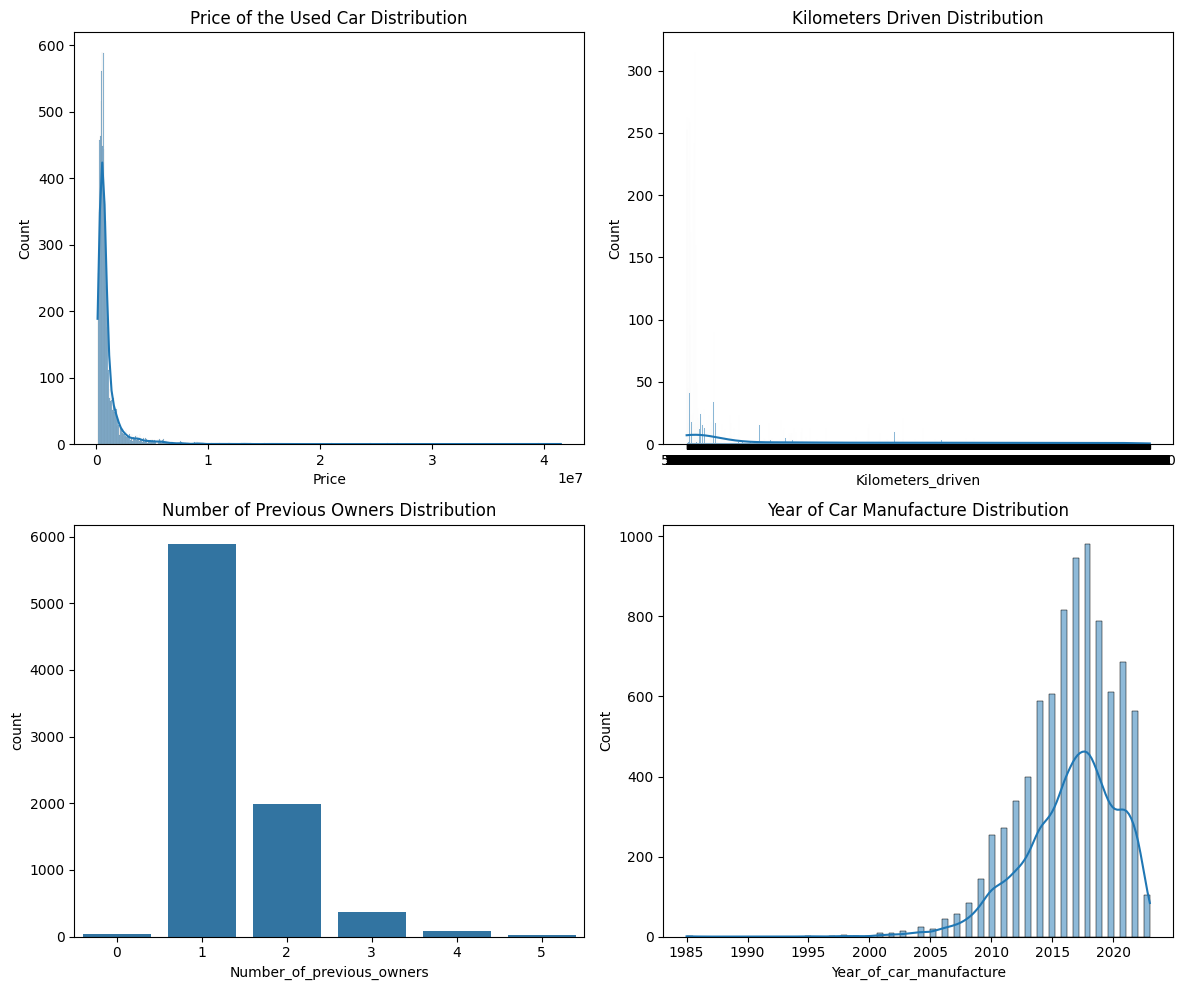

In [20]:
# Setting up the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot for Price_of_the_used_car
sns.histplot(data=df_1, x='Price', kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Price of the Used Car Distribution')

# Plot for Kms driven
sns.histplot(data=df_1, x='Kilometers_driven', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Kilometers Driven Distribution')

# Plot No of Previous owners
sns.countplot(data=df_1, x='Number_of_previous_owners', ax=axes[1, 0])
axes[1, 0].set_title('Number of Previous Owners Distribution')

# Plot Year_of_car_manufacture
sns.histplot(data=df_1, x='Year_of_car_manufacture', kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Year of Car Manufacture Distribution')


plt.tight_layout()
plt.show()

In [21]:
# Bar plot for Categorical features 
categorical_features = ['city', 'Fuel_type', 'Body_type', 'Transmission_type']
fig = go.Figure()

# Plotting count plots for categorical features

for feature in categorical_features:
    if feature == 'Body_type':
        fig.add_trace(go.Bar(x=df_1[feature].value_counts().index, 
                             y=df_1[feature].value_counts().values,
                             name=f'Distribution of {feature}', marker_color='lightskyblue'))
    else:
        fig.add_trace(go.Bar(x=df_1[feature].value_counts().index, 
                             y=df_1[feature].value_counts().values,
                             name=f'Distribution of {feature}'))

# Update layout for categorical features
fig.update_layout(title='Distribution of Categorical Features',
                  xaxis_title='Category',
                  yaxis_title='Count')


fig.show()

In [22]:
# Heat map for numerical features 
numerical_features = ['Price', 'Kilometers_driven', 'Number_of_previous_owners', 'Year_of_car_manufacture']

# correlation
correlation_matrix = df_1[numerical_features].corr()

# Create the heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='Viridis',
    colorbar=dict(title='Correlation'),
))

fig.show()

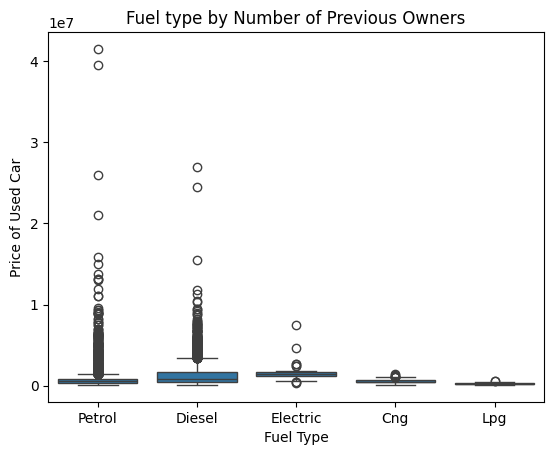

In [23]:
# Boxplot for fuel type

sns.boxplot(data=df_1, x='Fuel_type', y='Price')
plt.xlabel('Fuel Type')
plt.ylabel('Price of Used Car')
plt.title('Fuel type by Number of Previous Owners')
plt.show()



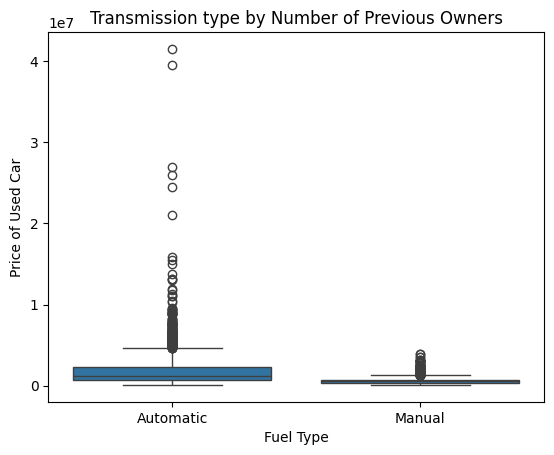

In [24]:
# Boxplot for tranmission type

sns.boxplot(data=df_1, x='Transmission_type', y='Price')
plt.xlabel('Fuel Type')
plt.ylabel('Price of Used Car')
plt.title('Transmission type by Number of Previous Owners')
plt.show()


In [25]:
df_1['Kilometers_driven'] = pd.to_numeric(df_1['Kilometers_driven'])

In [26]:
# Data Quality Checking

def perform_data_quality_checks(data):
    duplicate_rows = data[data.duplicated()]
    if not duplicate_rows.empty:
        print("Duplicate Rows:")
        print(duplicate_rows)
    else:
        print("No duplicate rows found.")

    missing_values = data.isnull().sum()
    if not missing_values.empty:
        print("\nMissing Values:")
        print(missing_values)
    else:
        print("\nNo missing values found.")

    data_types = data.dtypes
    print("\nData Types:")
    print(data_types)


perform_data_quality_checks(df_1)

Duplicate Rows:
              Car_model  Year_of_car_manufacture  Kilometers_driven  \
55          Maruti Ciaz                     2017              80000   
77        Maruti Baleno                     2016              53967   
78          Honda Amaze                     2014              99225   
179           MG Hector                     2022              20000   
194          Honda City                     2012              71423   
...                 ...                      ...                ...   
8044        Ford Aspire                     2015             100000   
8126  Mercedes-Benz CLA                     2018              40000   
8188         Kia Seltos                     2021              20000   
8324      Toyota Glanza                     2022              30000   
8342         Maruti SX4                     2009             110000   

      Number_of_previous_owners Transmission_type Fuel_type  Body_type  \
55                            1            Manual    Dies

In [27]:
# Selecting numerical columns
numeric_columns = df_1.select_dtypes(include=['number'])

# correlation 
correlation_with_price = numeric_columns.corr()['Price'].drop('Price')

# heatmap
fig = go.Figure(data=go.Heatmap(
    z=correlation_with_price.values.reshape(1, -1),
    x=correlation_with_price.index,
    y=['Price'],
    colorscale='RdBu',
    colorbar=dict(title='Correlation'),
))


fig.update_layout(
    title='Correlation with Price',
    xaxis_title='Features',
    yaxis_title='Price',
)
fig.show()

In [28]:
# ANOVA test to checking categorical columns are relating to output

categorical_columns = df_1.select_dtypes(include=['object'])

#list to store results
anova_results = []

# Performing ANOVA for each categorical column
for column in categorical_columns:
    model = ols('Price ~ ' + column, data=df_1).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table.loc[column, 'PR(>F)']
    anova_results.append((column, p_value))

# Print ANOVA results
for column, p_value in anova_results:
    if p_value < 0.05:  # Significance level of 0.05
        print(f'{column}: p-value = {p_value} (Statistically significant)')
    else:
        print(f'{column}: p-value = {p_value} (Not statistically significant)')


Car_model: p-value = 0.0 (Statistically significant)
Transmission_type: p-value = 0.0 (Statistically significant)
Fuel_type: p-value = 2.6815839817638937e-70 (Statistically significant)
Body_type: p-value = 4.8596930686127955e-282 (Statistically significant)
city: p-value = 1.193165787716217e-41 (Statistically significant)


In [31]:
# Remove duplicate rows from the dataset
df_1 = df_1.drop_duplicates()

# Verify if duplicates are removed
print("Original dataset length:", len(cars_list))
print("After removing Duplicates:", len(cars_list))

Original dataset length: 8369
After removing Duplicates: 8369


In [34]:
# Splitting columns for training and testing 

Inputs= df_1[['Car_model', 'Year_of_car_manufacture', 'Kilometers_driven',
       'Number_of_previous_owners', 'Transmission_type', 'Fuel_type',
       'Body_type','city']]

Output= df_1['Price']

# Initialising train_test_split
x_train,x_test,y_train,y_test=train_test_split(Inputs,Output,test_size=0.3,random_state=32)


In [35]:
# Checking for empty rows in x_train
empty_rows_train = x_train.isnull().any(axis=1)

# Checing for empty rows in x_test
empty_rows_test = x_test.isnull().any(axis=1)

print("Number of empty rows in x_train:", empty_rows_train.sum())
print("Number of empty rows in x_test:", empty_rows_test.sum())


Number of empty rows in x_train: 0
Number of empty rows in x_test: 0


In [36]:
# target encoder
encoder = ce.TargetEncoder(cols=['Car_model'])

# Fitting encoder into training data
encoder.fit(x_train, y_train)

# Transforming the 'Car_model' column in the training and testing sets
x_train['Car_model'] = encoder.transform(x_train)['Car_model']
x_test['Car_model'] = encoder.transform(x_test)['Car_model']


In [38]:
# Changing 'Manual' with 0 and 'Automatic' with 1 in the 'Transmission_type' column 
x_train['Transmission_type'].replace({'Manual': 0, 'Automatic': 1}, inplace=True)
x_test['Transmission_type'].replace({'Manual': 0, 'Automatic': 1}, inplace=True)

C:\Users\Vijay\AppData\Local\Temp\ipykernel_9376\1231591364.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Vijay\AppData\Local\Temp\ipykernel_9376\1231591364.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\Vijay\AppData\Local\Temp\ipykernel_9376\1231591364.py:3: FutureWarn

In [40]:

#mapping of fuel types to numerical values

fuel_type_mapping = {
    'Petrol': 1,
    'Diesel': 2,
    'Cng': 3,
    'Electric': 4,
    'Lpg': 5
}

# Apply mapping to the 'Fuel_type' column 
x_train['Fuel_type'] = x_train['Fuel_type'].map(fuel_type_mapping)
x_test['Fuel_type'] = x_test['Fuel_type'].map(fuel_type_mapping)


In [43]:
# Calculating the mean target value for categories in the 'Body_type' 
body_type_target_mean_train = y_train.groupby(x_train['Body_type']).mean()

#target encoder
encoder = ce.TargetEncoder(cols=['Body_type'])

# Fitting 
encoder.fit(x_train, y_train)

# Transforming the 'Body_type' column 
x_train['Body_type'] = encoder.transform(x_train)['Body_type']
x_test['Body_type'] = encoder.transform(x_test)['Body_type']

In [47]:
city_frequency_train = x_train['city'].value_counts(normalize=True)

# Replacing each category with its frequency in the training set
x_train['city'] = x_train['city'].map(city_frequency_train)


city_frequency_test = x_test['city'].value_counts(normalize=True)

# Replace each category with its frequency in the testing set
x_test['city'] = x_test['city'].map(city_frequency_train)

In [50]:
# Scaling
scaler=MinMaxScaler()
col=['Kilometers_driven','Year_of_car_manufacture','Number_of_previous_owners']

# Combining x_training and x_testing data for Scaling
combined_scale_data = pd.concat([x_train[col], x_test[col]], axis=0)

# Fitting 
scaler.fit(combined_scale_data)

# Encoding both training and testing data
x_train_scaled = scaler.transform(x_train[col])
x_test_scaled = scaler.transform(x_test[col])

# encoded values in the DataFrames
x_train[col] = x_train_scaled
x_test[col] = x_test_scaled

In [54]:
# Regression models and their respective hyperparameter grids

Regression_Models = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
    'Lasso Regression': (Lasso(), {'alpha': [0.1, 1.0, 10.0]}),
    'ElasticNet Regression': (ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]}),
    'Huber Regressor': (HuberRegressor(), {'epsilon': [1.0, 1.5, 2.0],'max_iter':[1000]}),
    'Bayesian Ridge Regression': (BayesianRidge(), {}),
    'Decision Tree': (DecisionTreeRegressor(), {'criterion': ['friedman_mse'], 'max_depth': [None, 5, 10]}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [3, 5, 7]}),
    'XG Boost': (XGBRegressor(), {'n_estimators': [100, 200, 300], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [3, 5, 7]}),
    #Support Vector Machine': (SVR(), {'kernel': ['linear', 'rbf'], 'C': [0.1, 1.0, 10.0]}),
    'K-Nearest Neighbors': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance']}),
}

for model_name, (model, param_grid) in Regression_Models.items():
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(x_train, y_train.values.ravel())  # Converting y_train to a 1D array using ravel()
    
    # Predict on test set
    y_pred = grid_search.predict(x_test)
    
    #  mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    # mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    
    #  R-squared score
    r2 = r2_score(y_test, y_pred)
    
   
    print(f"Model: {model_name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Mean Squared Error: {grid_search.best_score_}")
    print(f"Test Mean Squared Error: {mse}")
    print(f"Test Mean Absolute Error: {mae}")
    print(f"Test R-squared: {r2}")
    print()


Model: Linear Regression
Best Parameters: {}
Best Mean Squared Error: 0.5482861274735573
Test Mean Squared Error: 912331451673.7876
Test Mean Absolute Error: 435955.09953563585
Test R-squared: 0.5218874853013205

Model: Ridge Regression
Best Parameters: {'alpha': 1.0}
Best Mean Squared Error: 0.5519005492298832
Test Mean Squared Error: 912455819044.5585
Test Mean Absolute Error: 435705.8788900553
Test R-squared: 0.5218223098694347

Model: Lasso Regression
Best Parameters: {'alpha': 10.0}
Best Mean Squared Error: 0.5484357171754194
Test Mean Squared Error: 912323549419.1401
Test Mean Absolute Error: 435935.88573333895
Test R-squared: 0.5218916265230599

Model: ElasticNet Regression
Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.9}
Best Mean Squared Error: 0.5463494810564313
Test Mean Squared Error: 927739723045.1312
Test Mean Absolute Error: 434369.38160693616
Test R-squared: 0.5138126925722115

Model: Huber Regressor
Best Parameters: {'epsilon': 1.5, 'max_iter': 1000}
Best Mean Squared 

In [55]:

# Initialize PolynomialFeatures to create polynomial features
poly_features = PolynomialFeatures(degree=3)

# Transform the features to polynomial features
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.transform(x_test)

# Initialize Linear Regression model
model = LinearRegression()

# Train the model
model.fit(x_train_poly, y_train)

# Make predictions on the testing data
y_pred = model.predict(x_test_poly)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print()

Mean Squared Error: 539683703671.70514
Mean Absolute Error: 380081.89190497855
R-squared: 0.7171756687429902



In [56]:

# Generate quadratic features
x_train_quad = np.column_stack((x_train, x_train**2))
x_test_quad = np.column_stack((x_test, x_test**2))

# Initialize Linear Regression model
model = LinearRegression()

# Train the model
model.fit(x_train_quad, y_train)

# Make predictions on the testing data
y_pred = model.predict(x_test_quad)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")
print()

Mean Squared Error: 609394471521.3684
Mean Absolute Error: 376180.6183306221
R-squared: 0.6806433421888294



In [57]:
# Assuming 'data' is your DataFrame containing the features with outliers
# Replace 'Kilometers_driven' and 'Price_of_the_used_car' with the actual column names

# Calculate the interquartile range (IQR) for each feature
Q1 = df_1['Kilometers_driven'].quantile(0.25)
Q3 = df_1['Kilometers_driven'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the overall range of values for each feature
min_value = df_1['Kilometers_driven'].min()
max_value = df_1['Kilometers_driven'].max()
overall_range = max_value - min_value

# Calculate the ratio of IQR to overall range
outlier_magnitude_km = IQR / overall_range

print("Magnitude of outliers for Kilometers_driven:", outlier_magnitude_km)

# Repeat the same process for 'Price_of_the_used_car'
Q1 = df_1['Price'].quantile(0.25)
Q3 = df_1['Price'].quantile(0.75)
IQR = Q3 - Q1

min_value = df_1['Price'].min()
max_value = df_1['Price'].max()
overall_range = max_value - min_value

outlier_magnitude_price = IQR / overall_range

print("Magnitude of outliers for Price:", outlier_magnitude_price)


Magnitude of outliers for Kilometers_driven: 0.00909090909090909
Magnitude of outliers for Price: 0.013140096618357487


In [63]:

gb=GradientBoostingRegressor(learning_rate= 0.01, max_depth= 7, n_estimators= 200)
gb.fit(x_train,y_train)
y_pred=gb.predict(x_test)

# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)

print(mae)
print(r2)

217177.886924475
0.8409931307020133


In [64]:
file="GradientB_Model.pkl"
with open(file,'wb') as f:
    pickle.dump(gb,f)
with open(file,'rb') as f:
    pickle.load(f)


In [60]:
Inputs.to_csv('CarDheko.csv')